In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import jax
from jax import grad, jit
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
import time
from IPython.display import display, clear_output
from jax.scipy.linalg import cho_solve
from tqdm import trange
from utils import *

### Multimodal VBMC

In [97]:
#multimodal gaussian mixture pdf
def mixture_pdf(x, mu_params, s_params, weights=None):
    x = jnp.atleast_1d(x)
    mu_params = jnp.array(mu_params)
    s_params = jnp.array(s_params)

    n_points = x.shape[0]
    n_components = mu_params.shape[0]

    # default equal weights
    if weights is None:
        weights = jnp.ones(n_components)/n_components
    else:
        weights = jnp.array(weights)/jnp.sum(weights)

    t1 = 1.0/(jnp.sqrt(2*jnp.pi)*s_params)
    t2 = jnp.exp(-0.5*((x[:, None] - mu_params[None, :])/s_params[None, :])**2)
    terms = t1[None, :]*t2

    return jnp.sum(weights[None, :]*terms, axis=1)

#MC estimate of entropy of a multimodal gaussian
def entropy(mu_params, s_params, weights=None, n_samples=100,key=None):
    mu_params = jnp.array(mu_params)
    s_params = jnp.array(s_params)
    n_components = len(mu_params)
    key1, key2 = jax.random.split(key)

    #assume equal weights
    if weights is None:
        weights = jnp.ones_like(mu_params)/len(mu_params)
    else:
        weights = jnp.array(weights)/jnp.sum(weights)

    #sample from mixture
    mix = jax.random.choice(key1, n_components, shape=(n_samples,), p=weights)
    z = jax.random.normal(key2, shape=(n_samples,))
    samples = mu_params[mix] + s_params[mix]*z

    #compute pdf at sampled points
    pdf_vals = jax.vmap(lambda x: mixture_pdf(x, mu_params, s_params, weights))(samples)

    #return entropy
    h = -jnp.log(pdf_vals + 1e-12)
    return jnp.mean(h)


def log_joint(x_eval, y_eval, sigma, L, mu_params, s_params, weights=None):
    mu_params = jnp.array(mu_params)
    s_params = jnp.array(s_params)
    n_components = len(mu_params)
    
    x_eval = x_eval.reshape(-1, 1)
    y_eval = y_eval.reshape(-1, 1)
    
    #assume equal weights
    if weights is None:
        weights = jnp.ones(n_components)/n_components
    else:
        weights = jnp.array(weights)/jnp.sum(weights)

    #kernel matrix
    Kxx = rbf(x_eval, x_eval.T, sigma, L)
    Kxx += 1e-10*jnp.eye(len(Kxx))
    
    #cross-covariances for all components
    kFs = jnp.stack([vk1(x_eval, sigma, L, mu_params[i], s_params[i]).reshape(-1, 1)
                    for i in range(n_components)], axis=0)
    kF = jnp.sum(weights[:, None, None]*kFs, axis=0).reshape(-1, 1)
    
    #posterior mean
    mu = kF.T@jnp.linalg.solve(Kxx, y_eval)
    return mu[0, 0]

#ELBO computation for trimodal guassian
def elbo(params, x, y, s=1, L=1, n_mc=100, key=None):
    mu_params = params[0]
    s_params = jnp.exp(params[1])

    #compute expected log joint
    expected_log_joint = log_joint(x, y, s, L, mu_params,s_params)

    #entropy of Gaussian q
    entropy_q = entropy(mu_params,s_params, weights=None, n_samples=n_mc,key=key)

    #return negative elbo
    return -expected_log_joint - entropy_q

def expensive_log_likelihood(obs, params, weights=None):
    mu_params = params[0]
    s_params = params[1]

    mu_params = jnp.array(mu_params)
    s_params = jnp.array(s_params)
    n_components = len(mu_params)

    #assume equal weights
    if weights is None:
        weights = jnp.ones(n_components)/n_components
    else:
        weights = jnp.array(weights)/jnp.sum(weights)

    t1 = 1.0/(jnp.sqrt(2*jnp.pi)*s_params)
    t2 = jnp.exp(-0.5*((obs - mu_params)/s_params)**2)
    terms = t1*t2

    likelihood = jnp.sum(weights*terms, axis=1)
    log_likelihood = jnp.log(likelihood + 1e-12)
    return log_likelihood

#returns new gp points
def active_sample(x, y, proposed_points, params_true, params_q, s, L, alpha=1,beta=1,gamma=1,n_points=1):
    mu_true = params_true[0]
    s_true = params_true[1]

    mu_q = params_q[0]
    s_q = params_q[1]
    acquisition_values = jnp.zeros((int(n_points), int(proposed_points.shape[0])))
    for i in range(n_points):
        grad_fn = grad(neg_gp_likelihood)
        s_init = s
        l_init = L
        init_params = jnp.concatenate([jnp.ravel(s_init), l_init.ravel()])
        res = minimize(
            fun=lambda p: float(neg_gp_likelihood(p, x, y, rbf)),
            x0=init_params,
            jac=lambda p: jnp.array(grad_fn(p, x, y, rbf)),
            method="L-BFGS-B",
            bounds=[(1, 12)]*len(init_params)
            )
        #kernel hyperparameters
        s = res.x[0]
        L = jnp.diag(res.x[1:])
        
        mu, var = gp_predict(x, y, proposed_points, kernel=rbf, s=s, L=L)
        var = jnp.diag(var)
        q = mixture_pdf(proposed_points, mu_q, s_q)
        f_exp = jnp.exp(mu)
        
        acquisition_values = acquisition_values.at[i].set(var**alpha*q**beta*f_exp**gamma)
        
        #pick next point
        best_idx = jnp.argmax(acquisition_values[i])
        x_new = proposed_points[best_idx].reshape(-1,1)
        y_new = expensive_log_likelihood(x_new, params_true)
        x = jnp.vstack([x, x_new])
        y = jnp.concatenate([y, y_new])
        sorted_idx = jnp.argsort(x.flatten())
        x = x[sorted_idx]
        y = y[sorted_idx]
        
    return x, y, s, L, acquisition_values

def vbmc1(x, y, params, grad_elbo, s=5, L=5, lr=0.005, n1=10, n2=20_000, key=None):
    elbo_history = []
    best_elbo = -jnp.inf
    best_params = params.copy()
    for j in range(n1):
        for i in range(n2):
            key, _ = jax.random.split(key)
            grads = grad_elbo(params, x, y, s, L, key=key)
            params = params - lr*grads

            if (i+1) % (n2/2) == 0:
                current_elbo = -elbo(params, x, y, s, L, n_mc=50_000, key=key)
                elbo_history.append(current_elbo)
                if current_elbo > best_elbo:
                    best_elbo = current_elbo
                    best_params = params.copy()
                print(f"Iter {j+1}, {i+1}: ELBO = {current_elbo}")
    return best_params, best_elbo, elbo_history


def vbmc2(x, y, params, grad_elbo, s=5, L=5, alpha=1, 
          beta=1, gamma=1, lr=0.005, n_points=1, 
          n1=10, n2=20_000, plots=True, 
          real_log_likelihood=None, key=None):
    elbo_history = []
    best_elbo = -jnp.inf
    best_params = params.copy()
    x_eval = jnp.linspace(lower,upper,200)
    for j in range(n1):
        for i in range(n2):
            key, _ = jax.random.split(key)
            grads = grad_elbo(params, x, y, s, L, key=key)
            params = params - lr*grads

            if (i+1) % (n2/2) == 0:
                current_elbo = -elbo(params, x, y, s, L, n_mc=50_000, key=key)
                elbo_history.append(current_elbo)
                if current_elbo > best_elbo:
                    best_elbo = current_elbo
                    best_params = params.copy()
                print(f"Iter {j+1}, {i+1}: ELBO = {current_elbo}")
    
        s = jnp.atleast_1d(s)
        x, y, s, L, acquisition_values = active_sample(x, y, x_eval, params_true, best_params, 
                                                       s, L, alpha, beta, gamma, n_points)

        if plots:
            fig, axes = plt.subplots(1, 2, figsize=(16, 6))
            for i in range(acquisition_values.shape[0]):
                axes[0].plot(x_eval, acquisition_values[i], label=f'Iteration {i+1}')
            axes[0].set_xlabel("x")
            axes[0].set_ylabel("Acquisition Value")
            axes[0].set_title("Acquisition Functions")
            axes[0].legend()

            #plot gp
            mu_eval,var_eval = gp_predict(x,y,x_eval,kernel=rbf,s=s,L=L)
            sig_diag = jnp.sqrt(np.diag(var_eval))

            
            axes[1].plot(x_eval, mu_eval, lw=2, color='gray', label='GP Mean')
            axes[1].fill_between(x_eval.ravel(),
                                mu_eval.ravel() - 2*sig_diag.ravel(),
                                mu_eval.ravel() + 2*sig_diag.ravel(),
                                color='lightgray', label='95% CI')
            axes[1].scatter(x, y, c='red', s=20, label='Observed')
            axes[1].plot(x_eval, real_log_likelihood, label='True Log Likelihood')
            axes[1].set_xlabel("x")
            axes[1].set_ylabel("f(x)")
            axes[1].set_title("Log GP Surrogate")
            axes[1].set_ylim(-35, 0)
            axes[1].legend(loc='upper left')

            plt.tight_layout()
            plt.show()
        
    return best_params, best_elbo, elbo_history

Optimised params: [10.04663299  9.64106174]
Optimised log marginal likelihood: -45.675437735387945


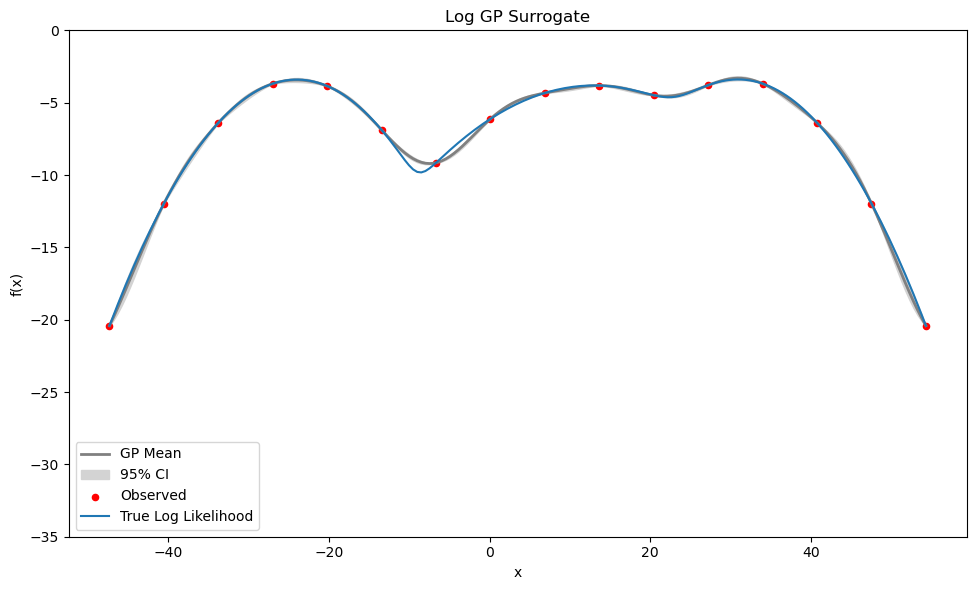

In [107]:
n = 16
mu_true = jnp.array([-24,13,31])
s_true = jnp.array([4,6,4])
params_true = jnp.array([mu_true, s_true])
lower = min(mu_true) - 5*jnp.mean(s_true)
upper = max(mu_true) + 5*jnp.mean(s_true)


x = jnp.linspace(lower,upper,n).reshape(-1, 1)
y = expensive_log_likelihood(x, params_true)

grad_fn = grad(neg_gp_likelihood)
s_init = 5
l_init = jnp.array([10])
init_params = jnp.concatenate([jnp.array([s_init]), l_init])

res = minimize(
    fun=lambda p: float(neg_gp_likelihood(p, x, y, rbf)),
    x0=init_params,
    jac=lambda p: jnp.array(grad_fn(p, x, y, rbf)),
    method="L-BFGS-B",
    bounds=[(3, 12)]*len(init_params)
)

#kernel hyperparameters
s = res.x[0]
L = jnp.diag(res.x[1:])

print("Optimised params:", res.x)
print("Optimised log marginal likelihood:", -res.fun)

x_eval = jnp.linspace(lower,upper,200)
mu_eval,var_eval = gp_predict(x,y,x_eval,kernel=rbf,s=s,L=L)
sig_diag = jnp.sqrt(np.diag(var_eval))

#plot gp
plt.figure(figsize=(10, 6))

plt.plot(x_eval, mu_eval, lw=2, color='gray', label='GP Mean')
plt.fill_between(x_eval.ravel(),
                mu_eval.ravel() - 2*sig_diag.ravel(),
                mu_eval.ravel() + 2*sig_diag.ravel(),
                color='lightgray', label='95% CI')


plt.scatter(x, y, c='red', s=20, label='Observed')
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Log GP Surrogate")
plt.legend(loc='upper left')
plt.tight_layout()


x_vals = jnp.linspace(lower, upper, 200).reshape(-1,1)
log_likelihood = expensive_log_likelihood(x_vals, params_true)

plt.plot(x_vals, log_likelihood, label='True Log Likelihood')
plt.ylim(-35,0)
plt.legend()
plt.show()

### Find variational posterior

$$
\log p(\mathbf{x}) = \underbrace{\mathbb{E}_q[\log p(\mathbf{z},\mathbf{x})] - \mathbb{E}_q[\log q(\mathbf{z})]}_{= ELBO} + \underbrace{\text{KL}(q(\mathbf{z})||p(\mathbf{z}|\mathbf{x}))}_{\ge 0}
$$

$$
\text{ELBO} = \underbrace{\mathbb{E}_q[\log p(\mathbf{z},\mathbf{x})]}_{=\text{Expected Log Joint}} + \underbrace{\left(-\mathbb{E}_q[\log q(\mathbf{z})]\right)}_{=\text{Entropy of Q}}
$$


 In this example, the expensive likelihood function $p(\mathbf{z}|\mathbf{x}) = p(\mathbf{x},\mathbf{z})$.

 - $\mathbb{E}_q[\log p(\mathbf{z},\mathbf{x})] = \mathbb{E}_q[\log p(\mathbf{z}|\mathbf{x})]$
 - Maximum $\text{ELBO}$ occurs when $\text{KL}(q(\mathbf{z})||p(\mathbf{z}|\mathbf{x})) = 0 \implies q(\mathbf{z}) = p(\mathbf{z}|\mathbf{x})$
 - This makes $\mathbb{E}_q[\log p(\mathbf{z}|\mathbf{x})]$ the negative entropy of Q.
 - This makes the maximum $\text{ELBO} = 0$ 


 Another way to see this is since $p(\mathbf{x},\mathbf{z}) = p(\mathbf{z}|\mathbf{x})p(\mathbf{x})$
 - Maximum $\text{ELBO}$ occurs when $\text{KL}(q(\mathbf{z})||p(\mathbf{z}|\mathbf{x})) = 0$ 
 - $\implies \log p(\mathbf{x}) = \text{ELBO} + \underbrace{\text{KL}(q(\mathbf{z})||p(\mathbf{z}|\mathbf{x}))}_{= 0} = 0$ since $p(\mathbf{x}) = 1$   



Iter 1, 10000: ELBO = 1.4732718097605169
Iter 1, 20000: ELBO = 1.5281081502437104
Iter 2, 10000: ELBO = 1.5523298382787374
Iter 2, 20000: ELBO = 1.5596975890941804
Iter 3, 10000: ELBO = 1.558197043671989
Iter 3, 20000: ELBO = 1.5615342826726115
Iter 4, 10000: ELBO = 1.5759536607174742
Iter 4, 20000: ELBO = 1.580209211190088
Iter 5, 10000: ELBO = 1.5896815232563002
Iter 5, 20000: ELBO = 1.5834711008463733
Iter 6, 10000: ELBO = 1.5845530177366953
Iter 6, 20000: ELBO = 1.5989196362695228
Iter 7, 10000: ELBO = 1.5946429407215983
Iter 7, 20000: ELBO = 1.6049205840959484
Iter 8, 10000: ELBO = 1.61847604147248
Iter 8, 20000: ELBO = 1.6242029752343856
Iter 9, 10000: ELBO = 1.636595077790521
Iter 9, 20000: ELBO = 1.6731528731052872
Iter 10, 10000: ELBO = 1.7539588185461343
Iter 10, 20000: ELBO = 1.9648282701422226

Best ELBO 1.9648282701422226
Parameter     Optimized         True
------------------------------------
mu1            -18.7128     -24.0000
mu2              1.3119      13.0000
mu3  

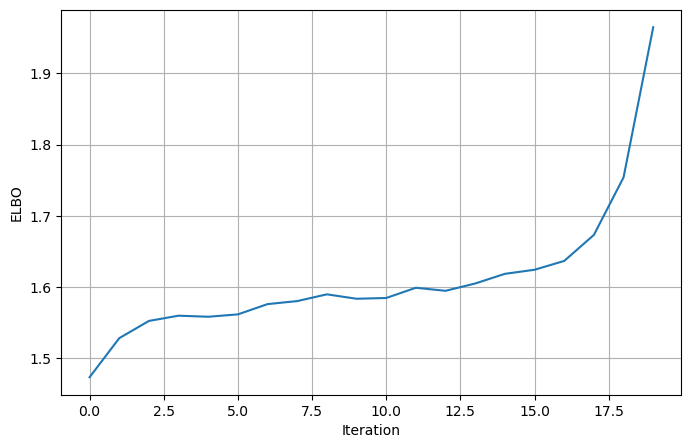

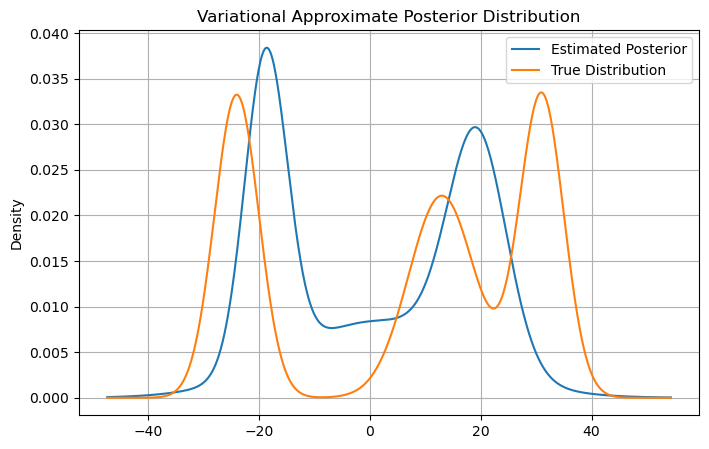

In [74]:
mu_initial = jnp.array([-13,-3,5])
s_initial = jnp.array([6,9,2])
params = jnp.array([mu_initial, jnp.log(s_initial)])
grad_elbo = jit(grad(elbo))
key = jax.random.PRNGKey(0)
params, best_elbo, elbo_history = vbmc1(x,y,params,grad_elbo, s, L, 0.005, 10, 20_000,key)


n_components = len(mu_initial)
mu_opt = params[0]
s_opt = jnp.exp(params[1]) 

# Create names dynamically
param_names = [f"mu{i+1}" for i in range(n_components)] + \
              [f"sigma{i+1}" for i in range(n_components)]

# Combine optimized and true values
optimized_vals = jnp.concatenate([mu_opt, s_opt]).flatten()
true_vals = jnp.concatenate([jnp.array(mu_true), jnp.array(s_true)]).flatten()

# Print results neatly
print()
print("Best ELBO", best_elbo)
print(f"{'Parameter':<10} {'Optimized':>12} {'True':>12}")
print("-"*36)
for name, opt, true in zip(param_names, optimized_vals, true_vals):
    print(f"{name:<10} {float(opt):12.4f} {float(true):12.4f}")

# Plot ELBO history
plt.figure(figsize=(8,5))
plt.plot(elbo_history)
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.show()


#plot range
x_min = lower
x_max = upper
x_vals = jnp.linspace(x_min, x_max, 1000).reshape(-1,1)

#estimated mixture PDF
pdf_vals = jax.vmap(lambda x: mixture_pdf(x, mu_params=mu_opt, s_params=s_opt))(x_vals)

#true pdf
true_vals = jnp.exp(expensive_log_likelihood(x_vals, params_true))

#compare estimated and true distributions
plt.figure(figsize=(8,5))
plt.plot(x_vals, pdf_vals, label='Estimated Posterior')
plt.plot(x_vals, true_vals, label='True Distribution')
plt.title('Variational Approximate Posterior Distribution')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

Iter 1, 15000: ELBO = -0.4513857270908401
Iter 1, 30000: ELBO = -0.3744231615781404
Iter 2, 15000: ELBO = -0.34162369888757826
Iter 2, 30000: ELBO = -0.3103165393766245
Iter 3, 15000: ELBO = -0.14384462086637573
Iter 3, 30000: ELBO = -0.058602663541504896
Iter 4, 15000: ELBO = -0.018020208984213415
Iter 4, 30000: ELBO = 0.0069127696411488415
Iter 5, 15000: ELBO = 0.00020498922028178157
Iter 5, 30000: ELBO = 0.0054058776947516485
Iter 6, 15000: ELBO = 0.0022586267596818033
Iter 6, 30000: ELBO = 0.003985479003632886
Iter 7, 15000: ELBO = 0.0011163600136989693
Iter 7, 30000: ELBO = -0.0017485103716676775
Iter 8, 15000: ELBO = 0.0009820601585399658
Iter 8, 30000: ELBO = 0.00045571932417409755
Iter 9, 15000: ELBO = -0.0025029556593958446
Iter 9, 30000: ELBO = 0.0012401459692492622
Iter 10, 15000: ELBO = 0.006204556708408138
Iter 10, 30000: ELBO = 0.003648697372773846

Best ELBO 0.0069127696411488415
Parameter     Optimized         True
------------------------------------
mu1            -23

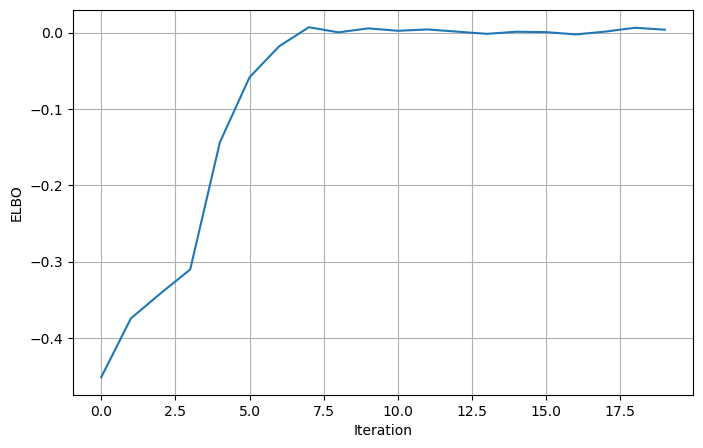

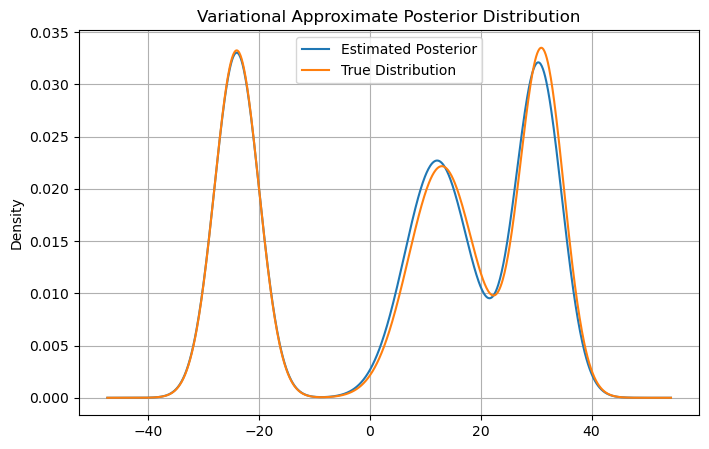

In [110]:
#initial values
mu_initial = jnp.array([-15,-3,15])
s_initial = jnp.array([6,4,2])
params = jnp.array([mu_initial, jnp.log(s_initial)])
x_eval = jnp.linspace(lower,upper,200)
grad_elbo = jit(grad(elbo))
key = jax.random.PRNGKey(0)


params, best_elbo, elbo_history = vbmc2(x,y,params,grad_elbo,s,L,
                                        alpha=3, beta=0.3, gamma=1.3,
                                        lr=0.01, n_points=0,n1= 10,
                                        n2=30_000, plots=False,
                                        real_log_likelihood=log_likelihood, 
                                        key=key)

n_components = len(mu_initial)
mu_opt = params[0]
s_opt = jnp.exp(params[1]) 

# Create names dynamically
param_names = [f"mu{i+1}" for i in range(n_components)] + \
              [f"sigma{i+1}" for i in range(n_components)]

# Combine optimized and true values
optimized_vals = jnp.concatenate([mu_opt, s_opt]).flatten()
true_vals = jnp.concatenate([jnp.array(mu_true), jnp.array(s_true)]).flatten()

# Print results neatly
print()
print("Best ELBO", best_elbo)
print(f"{'Parameter':<10} {'Optimized':>12} {'True':>12}")
print("-"*36)
for name, opt, true in zip(param_names, optimized_vals, true_vals):
    print(f"{name:<10} {float(opt):12.4f} {float(true):12.4f}")

# Plot ELBO history
plt.figure(figsize=(8,5))
plt.plot(elbo_history)
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.show()


#plot range
x_min = lower
x_max = upper
x_vals = jnp.linspace(x_min, x_max, 1000).reshape(-1,1)

#estimated mixture PDF
pdf_vals = jax.vmap(lambda x: mixture_pdf(x, mu_params=mu_opt, s_params=s_opt))(x_vals)

#true pdf
true_vals = jnp.exp(expensive_log_likelihood(x_vals, params_true))

#compare estimated and true distributions
plt.figure(figsize=(8,5))
plt.plot(x_vals, pdf_vals, label='Estimated Posterior')
plt.plot(x_vals, true_vals, label='True Distribution')
plt.title('Variational Approximate Posterior Distribution')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()